In [9]:
# Das Notebook basiert auf diesem Turoial:
# https://www.analyticsvidhya.com/blog/2019/09/step-by-step-deep-learning-tutorial-video-classification-python/

# Training the model starts here

In [1]:
#imports
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report

In [2]:
# read in csv with labels for frames
train = pd.read_csv('material/train_frames.csv')

In [3]:
# reading in all the frames and saving them to a numpy array

# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the image size (480, 640, 3)
    '''
    TO DO:
    finde heraus was die ideale input größe der bilder ist. 
    '''
    img = image.load_img('material/train_frames/'+train['image'][i], target_size=(480, 640, 3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    '''
    TO DO:
    finde heraus was die optimale normalisierung der Bild daten ist
    '''
    img = img/480
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|██████████| 8300/8300 [00:42<00:00, 193.60it/s]


(8300, 480, 640, 3)

In [ ]:
# creating train and test set

# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [5]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the architecture of the model

In [6]:
# model without transferlearning based on:
# https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
init="he_normal"
inputShape = (480, 640, 3)
reg = l2(0.0005)
chanDim = -1

model = Sequential()
model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
                 kernel_initializer=init, kernel_regularizer=reg,input_shape=inputShape))

# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# stack two more CONV layers, keeping the size of each filter
# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))
# increase the number of filters again, this time to 128
model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# fully-connected layer
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(4))
model.add(Activation("softmax"))
# return the constructed network architecture

In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 237, 317, 16)      2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 237, 317, 32)      4640      
_________________________________________________________________
activation (Activation)      (None, 237, 317, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 237, 317, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 159, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 119, 159, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 119, 159, 32)      1

In [8]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight_v2.1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [9]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

### Model wird hier trainiert

In [10]:
%%time
# training the model 

version2 = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Epoch 1/25
52/52 [==============================] - 41s 788ms/step - loss: 0.6062 - accuracy: 0.9658 - val_loss: 7.5193 - val_accuracy: 0.2199
Epoch 2/25
52/52 [==============================] - 42s 809ms/step - loss: 0.4500 - accuracy: 0.9998 - val_loss: 5.9238 - val_accuracy: 0.4807
Epoch 3/25
52/52 [==============================] - 28s 540ms/step - loss: 0.4311 - accuracy: 1.0000 - val_loss: 6.5491 - val_accuracy: 0.4416
Epoch 4/25
52/52 [==============================] - 41s 793ms/step - loss: 0.4102 - accuracy: 1.0000 - val_loss: 3.2362 - val_accuracy: 0.4970
Epoch 5/25
52/52 [==============================] - 54s 1s/step - loss: 0.3886 - accuracy: 0.9998 - val_loss: 1.1418 - val_accuracy: 0.7861
Epoch 6/25
52/52 [==============================] - 35s 665ms/step - loss: 0.3733 - accuracy: 0.9983 - val_loss: 0.5474 - val_accuracy: 0.9325
Epoch 7/25
52/52 [==============================] - 26s 491ms/step - loss: 0.3532 - accuracy: 0.9986 - val_loss: 0.9230 - val_accuracy: 0.8367
Ep

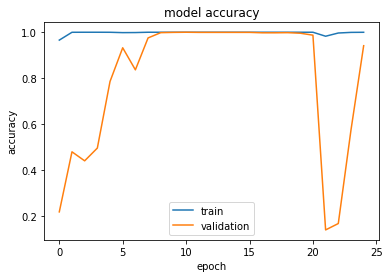

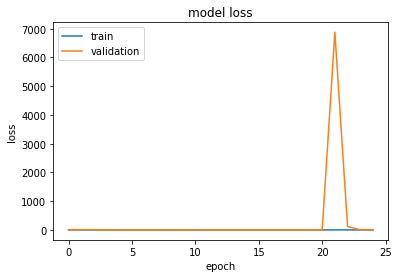

In [11]:
# plot training history
#  "Accuracy"
plt.plot(version2.history['accuracy'])
plt.plot(version2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# "Loss"
plt.plot(version2.history['loss'])
plt.plot(version2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation']) #loc='lower right'
plt.show()

In [13]:
model.evaluate(X_train, y_train)

208/208 [==============================] - 9s 42ms/step - loss: 0.3084 - accuracy: 0.9479


[0.3084007799625397, 0.9478915929794312]

In [14]:
acc = version2.history['accuracy']
np.amax(acc)

1.0

In [16]:
print("[INFO] evaluating network...")
y_test_numeric = y_test.rename(columns={"downwards": 0, "front": 1, "side": 2, "upwards": 3})
predictions = model.predict(x=X_test, batch_size=128)
print(classification_report(y_test_numeric.idxmax(axis="columns").values,
                            predictions.argmax(axis=1), target_names=['downwards', 'front', 'side', 'upwards']))

[INFO] evaluating network...
              precision    recall  f1-score   support

   downwards       1.00      1.00      1.00       221
       front       1.00      1.00      1.00       467
        side       1.00      0.89      0.94       892
     upwards       0.45      1.00      0.62        80

    accuracy                           0.94      1660
   macro avg       0.86      0.97      0.89      1660
weighted avg       0.97      0.94      0.95      1660



# Evaluating our Video Classification Model

## Defining Model architecture and loading weights

In [17]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization

In [18]:
# model without transferlearning based on:
# https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
init="he_normal"
inputShape = (480, 640, 3)
reg = l2(0.0005)
chanDim = -1

model = Sequential()
model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid",
                 kernel_initializer=init, kernel_regularizer=reg,input_shape=inputShape))

# here we stack two CONV layers on top of each other where
# each layerswill learn a total of 32 (3x3) filters
model.add(Conv2D(32, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# stack two more CONV layers, keeping the size of each filter
# as 3x3 but increasing to 64 total learned filters
model.add(Conv2D(64, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))
# increase the number of filters again, this time to 128
model.add(Conv2D(128, (3, 3), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same",kernel_initializer=init, kernel_regularizer=reg))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Dropout(0.25))

# fully-connected layer
model.add(Flatten())
model.add(Dense(512, kernel_initializer=init))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(4))
model.add(Activation("softmax"))
# return the constructed network architecture

In [19]:
# loading the trained weights
model.load_weights("weight_v2.1.hdf5")

# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

## Generating predictions for all test videos

In [20]:
# reading in test labels for verification later
train = pd.read_csv('material/test_labels.csv', sep=';')

# creating the dummy tags
trainLabel = pd.read_csv('material/train_frames.csv')
y = trainLabel['class']
y = pd.get_dummies(y)

In [21]:
# creating two lists to store predicted and actual tags
predict = []
actual = []

# for loop to extract frames from each test video
for i in tqdm(range(train['NameOfFile'].shape[0])):
    count = 0
    videoFile = train['NameOfFile'][i]
    cap = cv2.VideoCapture('material/raw_test_videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    
    # removing all other files from the temp folder
    files = glob('temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        #if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
        else:
            filename ='temp/' + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(480, 640, 3))
        img = image.img_to_array(img)
        img = img/480
        prediction_images.append(img)
    
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)

    # predicting tags for each array
    # predicting tags for each array
    prediction = (model.predict(prediction_images) > 0.5).astype("int32")
    predictFrame = []
    for pre in prediction:
        if pre[0] == 1:
            predictFrame.append('downwards')
        elif pre[1] == 1:
            predictFrame.append('front')
        elif pre[2] == 1:
            predictFrame.append('side')
        else:
            predictFrame.append('upwards')

    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(s.mode(predictFrame)[0][0])
    
    # appending the actual tag of the video
    actual.append(train['label'].loc[train['NameOfFile'] == videoFile].values[0])

100%|██████████| 24/24 [00:32<00:00,  1.37s/it]


In [22]:
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

100.0

In [7]:
predict

['side',
 'front',
 'downwards',
 'front',
 'side',
 'side',
 'front',
 'side',
 'downwards',
 'front',
 'side',
 'downwards',
 'side',
 'downwards',
 'front',
 'side',
 'front',
 'downwards',
 'side',
 'front',
 'side',
 'front',
 'side',
 'side']

In [8]:
actual

['side',
 'front',
 'downwards',
 'front',
 'side',
 'side',
 'front',
 'side',
 'downwards',
 'front',
 'side',
 'downwards',
 'side',
 'downwards',
 'front',
 'side',
 'front',
 'downwards',
 'side',
 'front',
 'side',
 'front',
 'side',
 'side']

# Evaluate Model by looking at Frame prediction

In [23]:
# reading in test labels for verification later
train = pd.read_csv('material/test_labels.csv', sep=';')

# creating the dummy tags
trainLabel = pd.read_csv('material/train_frames.csv')
y = trainLabel['class']
y = pd.get_dummies(y)

In [24]:
# create all frames and csv with labels and frame name

# clear temp folder
files = glob('temp/*')
for f in files:
    os.remove(f)

frameFileNames = []
frameFileLabels = []

# for loop to extract frames from each test video
for i in tqdm(range(train['NameOfFile'].shape[0])):
    count = 0
    videoFile = train['NameOfFile'][i]
    cap = cv2.VideoCapture('material/raw_test_videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1

    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        else:
            filename ='temp/' + videoFile + "_frame%d.jpg" % count;count+=1
            frameFileNames.append(filename)
            frameFileLabels.append(train['label'][i])
            cv2.imwrite(filename, frame)
    cap.release()


# storing the images and their labels in a dataframe
test_frames = pd.DataFrame()
test_frames['image'] = frameFileNames
test_frames['label'] = frameFileLabels

# converting the dataframe into csv file 
test_frames.to_csv('temp/test_frames.csv',header=True, index=False)

100%|██████████| 24/24 [00:11<00:00,  2.08it/s]


In [25]:
# make predicitons on all frames


# creating two lists to store predicted and actual tags
predictFrame = []
actualFrame = []
frameName = []

# reading all the frames from temp folder
images = glob("temp/*.jpg")

# reading actual labels from temp folder
train = pd.read_csv('temp/test_frames.csv')

# open all frames and convert to np array
prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(480, 640, 3))
    img = image.img_to_array(img)
    img = img/480
    prediction_images.append(img)
    actualFrame.append(train['label'].loc[train['image'] == images[i]].values[0])
    frameName.append(images[i].split('/')[1])

# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)

# predicting tags for each array
prediction = (model.predict(prediction_images) > 0.5).astype("int32")
for pre in prediction:
    if pre[0] == 1:
        predictFrame.append('downwards')
    elif pre[1] == 1:
        predictFrame.append('front')
    elif pre[2] == 1:
        predictFrame.append('side')
    else:
        predictFrame.append('upwards')

In [26]:
# checking predicted and actual frames labels which dont match
count_corrcet = 0
count_false = 0
for i in range(0, len(predictFrame)):
    if predictFrame[i] == actualFrame[i]:
        count_corrcet +=1
    else:
        print('frame ' + str(i),predictFrame[i], actualFrame[i])
        #print(frameName[i])
        count_false +=1

test_acc = (count_corrcet / (count_corrcet + count_false)) *100
print('Test Accuracy {:.2f}%'.format(test_acc))

Test Accuracy 100.00%


# Evaluate single Video

In [13]:
# clear temp folder
files = glob('temp/*')
for f in files:
    os.remove(f)

# extract frames from the video and store them
count = 0
videoFile = '_tigfCJFLZg_00214.mp4' # should be "downwards" but is "front"
#videoFile = '_8Vy3dlHg2w_00001.mp4' # should be "upwards" is "upwards"
#videoFile = '3PLiUG_DuC8_00346.mp4' # should be "upwards" but is "downwards"
#videoFile = '_tigfCJFLZg_00181.mp4' # should be "side" is "side"
# videoFile = 'Video_62.mp4' # should be "front" but includes camera switch
cap = cv2.VideoCapture('material/single_videos/'+videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    else:
        filename ='temp/' + videoFile + "_frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

# creating two lists to store predicted and actual tags
predictFrame = []

# reading all the frames from temp folder
images = glob("temp/*.jpg")

# open all frames and convert to np array
prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(480, 640, 3))
    img = image.img_to_array(img)
    img = img/480
    prediction_images.append(img)

# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)

# predicting tags for each array
prediction = (model.predict(prediction_images) > 0.5).astype("int32")
for pre in prediction:
    if pre[0] == 1:
        predictFrame.append('downwards')
    elif pre[1] == 1:
        predictFrame.append('front')
    elif pre[2] == 1:
        predictFrame.append('side')
    else:
        predictFrame.append('upwards')

In [14]:
predictFrame

['side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side']

In [15]:
#most labels say:
s.mode(predictFrame)[0][0]

'side'

In [17]:
# checking predicted and actual frames labels which dont match
counterA = 0
counterB = 0
for i in range(0, len(predictFrame)):
    if predictFrame[i] == 'downwards':
        counterA +=1
    else:
        counterB +=1 
print('correct: ', counterA, 'false: ',counterB)

correct:  0 false:  90
